# Magnetic Fields (1st try)

We have seen linear and diffuse motion. We will now analyse where in this range the motion of charged particles in a magnetic field takes place, depending on the strength of the field.

CRPropa offers the PropagationCK module for this, but we need to apply the magnetic field to a vector grid first.

In [1]:
from crpropa import *

randomSeed = 42
vgrid = VectorGrid(Vector3d(0), 256, 30*kpc)
initTurbulence(vgrid, 10*nG, 100*kpc, 1000*kpc, -11./3., randomSeed)
Bfield = MagneticFieldGrid(vgrid)

sim = ModuleList()
sim.add(PropagationCK(Bfield))
sim.add(MaximumTrajectoryLength(100*Mpc))

The trajectory will be stored in memory and a source is generating protons. We now need to specify the energy of the particles.

In [2]:
output = ParticleCollector(10000)
output.setClone(True)
sim.add(output)

source = Source()
source.add(SourceParticleType(nucleusId(1, 1)))
source.add(SourcePowerLawSpectrum(1*EeV, 1*EeV, -1))
source.add(SourceIsotropicEmission())
source.add(SourcePosition(Vector3d(0, 0, 0)*Mpc))

Then we start the simulation and plot the results as before.

In [3]:
sim.run(source, 30, False)

88601


<IPython.core.display.Javascript object>


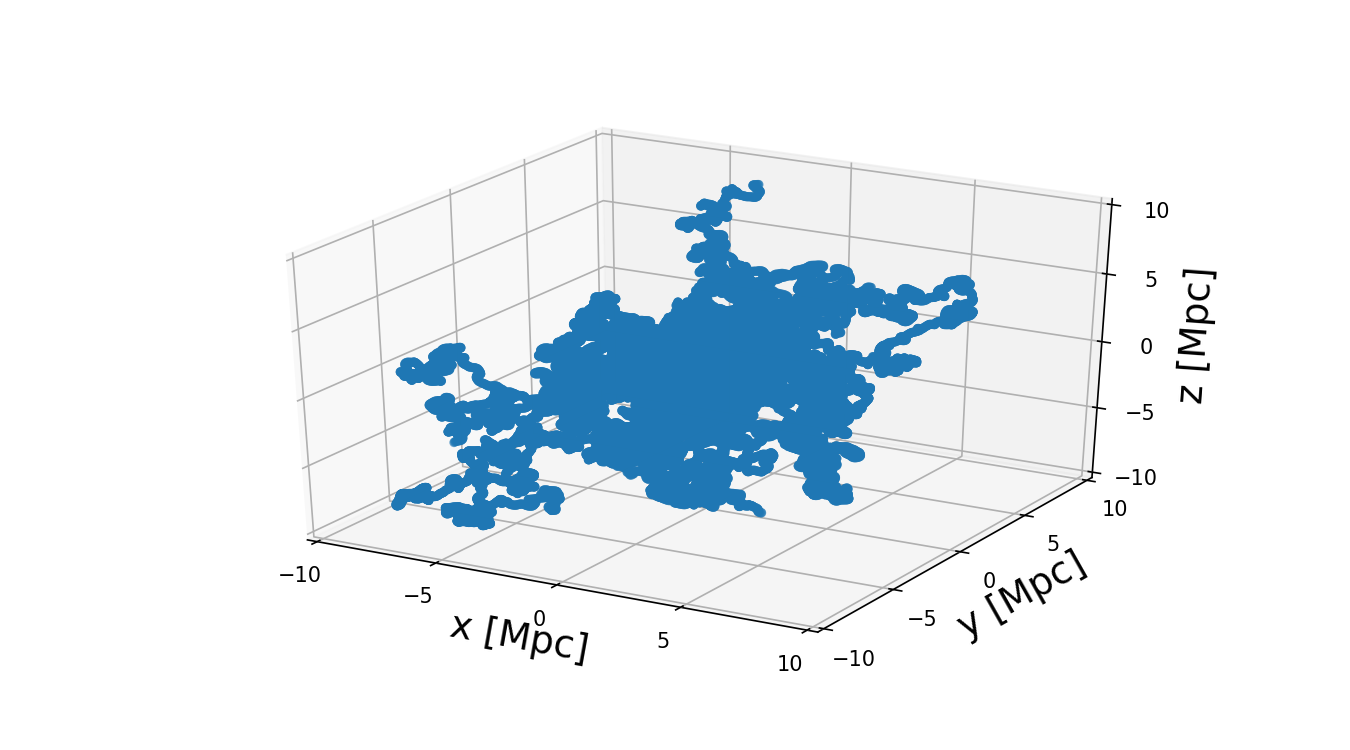

In [4]:
%matplotlib notebook
from pylab import *
from mpl_toolkits.mplot3d import axes3d

data = []
for c in output:
    pos = c.current.getPosition()
    data.append([c.getTrajectoryLength(), pos.getX(), pos.getY(), pos.getZ()])
data = np.array(data) / Mpc
print(output.size())
# trajectory points
x, y, z = data[:,1], data[:,2], data[:,3]

fig = plt.figure(figsize=(9, 5))#plt.figaspect(0.5))
ax = fig.gca(projection='3d')# , aspect='equal'

ax.scatter(x,y,z, 'o', lw=0)

ax.set_xlabel('x [Mpc]', fontsize=18)
ax.set_ylabel('y [Mpc]', fontsize=18)
ax.set_zlabel('z [Mpc]', fontsize=18)
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_zlim((-10, 10))
ax.xaxis.set_ticks((-10, -5, 0, 5, 10))
ax.yaxis.set_ticks((-10, -5, 0, 5, 10))
ax.zaxis.set_ticks((-10, -5, 0, 5, 10))

show()

So far so good, we applied a magnetic field and the particles move like we expected.

Now we start analysis. Later we will see that we have some problems here when building the averages for each step.

In [5]:
from collections import defaultdict
import numpy as np
grouped = defaultdict(list)
d = []
r_sq = []
d_end = 0
#print(data.dtype.names)
for di, X, Y, Z in data:
    grouped[di].append(X**2 + Y**2 + Z**2)
for di in grouped: 
    d.append(di)
    r_sq.append(np.mean(grouped[di]))
    d_end = max(d_end, di)
print('After last step:')
print('r_min   = ' + str(sqrt(np.min(grouped[d_end]))))
print('r_max   = ' + str(sqrt(np.max(grouped[d_end]))))
r_avg = np.mean(sqrt(grouped[d_end]))
print('< r >   = ' + str(r_avg))
print('< r >²  = ' + str(r_avg**2))
r_sq_avg = np.mean(grouped[d_end])
print('< r² >  = ' + str(r_sq_avg))
print('sigma_r = ' + str(sqrt(r_sq_avg - r_avg**2)))


After last step:
r_min   = 2.06088130404
r_max   = 14.7537098826
< r >   = 7.22926585474
< r >²  = 52.2622847986
< r² >  = 60.1059021358
sigma_r = 2.80064587859


Now we are especially interested in the resulting diffusion constant D and the fitting curve to < r² >(d).

In [6]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*(x**b)

popt, pcov = curve_fit(func, d, r_sq, bounds=(0, [4.0, 2.0]))
D = popt[0]
alpha = popt[1]
print('D = ' + str(D))
print('alpha = ' + str(D))
print()
print('r_sq = ' + str(D) + ' d ^ ' + str(alpha))

D = 0.595657320906
alpha = 0.595657320906

r_sq = 0.595657320906 d ^ 1.0021528976


<IPython.core.display.Javascript object>


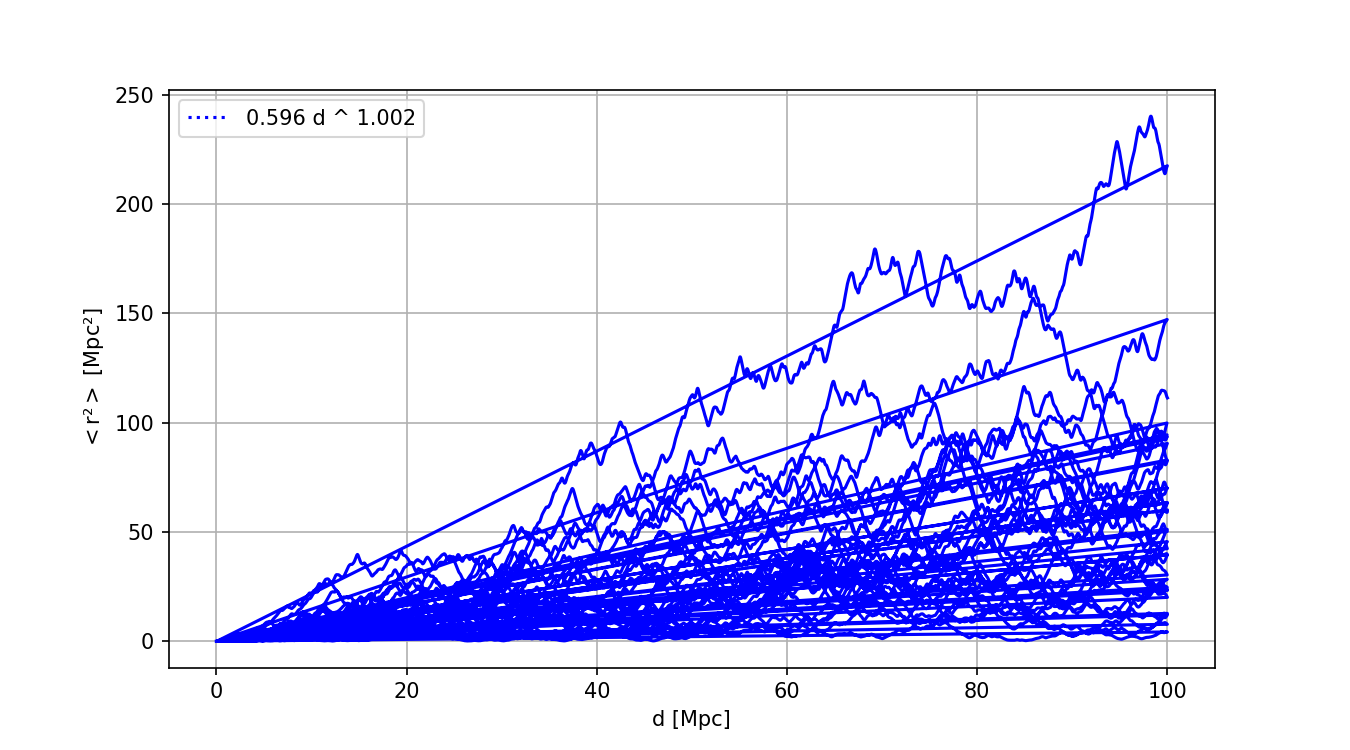

In [7]:
figure(figsize=(9, 5))
plot(d, r_sq, 'b-')
plot(d, func(d, D, alpha), 'b:', label='%.3f d ^ %.3f' % tuple(popt))
grid()
ylabel('$<$r²$>$ [Mpc²]')
xlabel('d [Mpc]')
legend()
show()

This looks NOT like we expected. This isn't even a single y=f(x) plot. It rather looks like we plotted each individual particle instead of building averages. And it turns out it very likely is what we did. 

But first we do some causality checks.

<IPython.core.display.Javascript object>


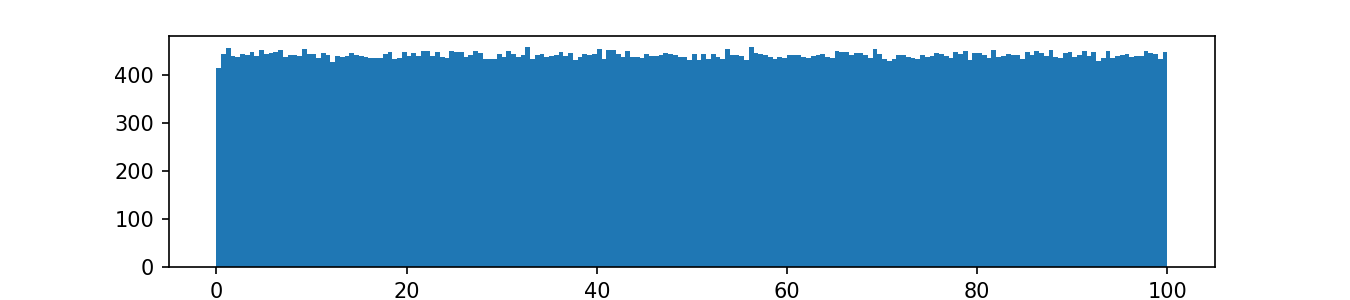

<IPython.core.display.Javascript object>


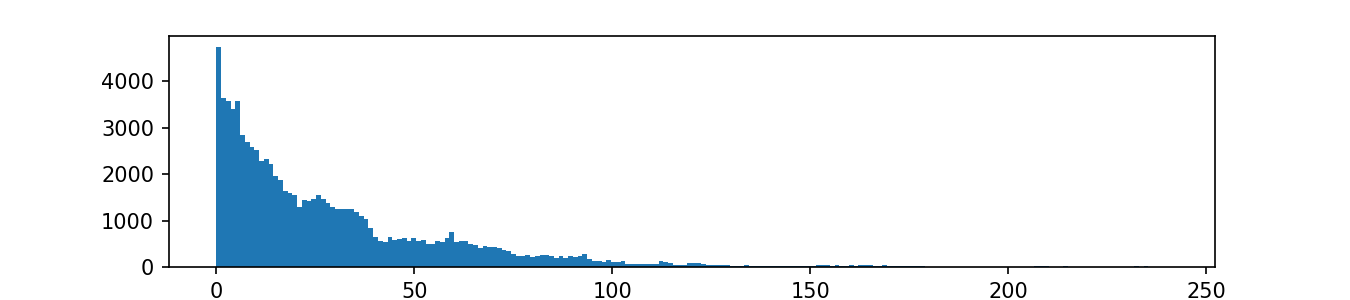

<IPython.core.display.Javascript object>


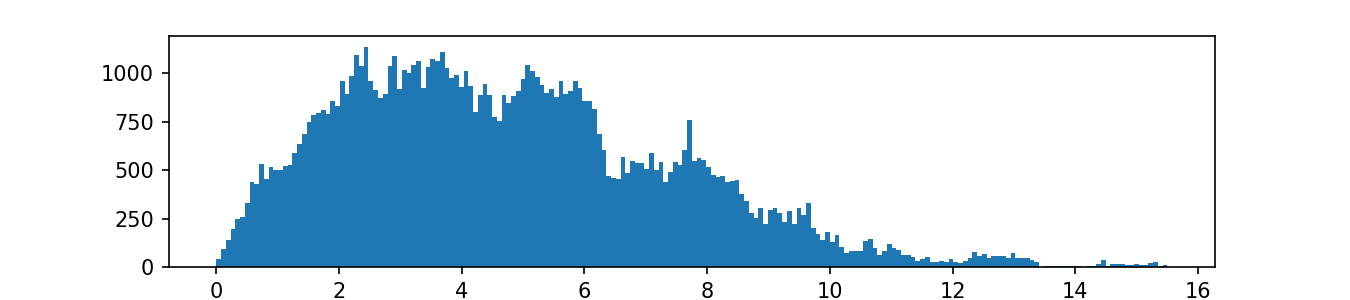

In [8]:
figure(figsize=(9, 2))
hist(d, bins=200)
show()
figure(figsize=(9, 2))
hist(r_sq, bins=200)
show()
figure(figsize=(9, 2))
hist(sqrt(r_sq), bins=200)
show()

On the first histogram we can see that the length of the trajectories d is almost evenly spread. But is is not constant. This means not every occuring value of d has happend for every particle. And this is because we did not set the PropagationCK module to fixed min = max step size. 

We now could again set min = max step size for PropagationCK module. The problem with setting max step size is only performance. We would calculate more steps in regions where the module knows from the B field, that we can go further ahead. The problem with setting min step size is more critical, as in regions with high B field the trajectory gets quite bended. To follow the theoretical continous trajectory the module reduces the step size to follow the curvature more closely. So we could only set min step size without changing the result too much, if we knew beforehand what global min step would be appropriate.

The second and third histogramm of < r² > and sqrt(< r² >) show us a quite reasonable distribution for diffuse motion. Only a few particles got furthest, most particles got turned quite often and stuck near the origin.

Conclusion is, the simulation did work out well and described diffusion like motion. But we have some issues with the idea of building an average over all particles for each step. Not every particle participates in each step and the definition of what exactly is a step got vague and unusable for our analysis approach. 

We need to rethink our analysis.